# 3장: 첫 번째 GAN

<!-- <table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-3/Chapter_3_GAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table> -->

In [42]:
# %matplotlib inline # 주피터 노트북에서 사용하는 매직명령어, 맷플랏립으로 생성된 그래프를 노트북 내에서 보여주기 위한 명령어
# 이걸 사용하면 맷플랏립 그래프를 별도의 창이 아닌 노트북 셀 내에서 바로 확인할 수 있음. 

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU # LeakyReLU(Leaky Rectified Linear Unit) 활성화 함수 중 하나로, 렐루 함수에서 발생하는
# 문제점을 보완하기 위해 만들어진 함수, 렐루는 입력값이 0보다 작으면 출력이 0 이 되는데, 이로인해 해당 뉴런은 더 이상 학습을 진행하지 않게 되는 
# 죽은 뉴런현상이 발생할 수 있음. LeakyReLU함수는 이를 방지하기 위해 입력값이 0보다 작을 떄 일정한 값을 곱하여 출력값을 계산.
# 이 값은 일반적으로 0.01로 설정됨. 이를 통해 음수영역에서도 기울기가 작아져 뉴런이 죽지 않음.
# 쉽게 말해 0 이하로 떨어지면 계산안되니 미리 0.01을 곱해서 0으로 안떨어지게 만든다는 뜻. 
from tensorflow.keras.models import Sequential # 케라스 모델을 구성하는 방법 중 하나로, 여러층을 차례대로 쌓아서 모델은 만드는 방법임. 
# 입력층에서 출력층까지 각 층을 일렬로 연결하여 모델을 생성함. 이를 통해 간단하게 신경망 모델을 만들 수 있음. 
from tensorflow.keras.optimizers import Adam

In [43]:
img_rows = 28 # 세로
img_cols = 28 # 가로
channels = 1 # 흑백이라서 1 , 컬러라면 3

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100 # 잡음벡터의 차원을 키우면 생성자가 생성하는 이미지의 다양성이 증가, 차원을 줄이면 생성된 이미지가 단순해짐. 이미지의 다양성 조절하는데 중요함.
# 잡음벡터의 차원이 너무 커지면, 가짜 이미지의 다양성이 늘어나서, 판별자를 속이기 어려워짐. 차원을 너무 키우면 생성자가 만들어내는 이미지가 현실적이지
# 않음. 적절하게 조절해야 함. 

## 생성자

In [44]:
def build_generator(img_shape, z_dim): # 이미지의 크기를 집어넣고, 잡음벡터를 삽입

    model = Sequential() # 기본적인 틀을 생성 층으로 이어진 모델층을 생성. 

    # 완전 연결층
    model.add(Dense(128, input_dim=z_dim)) # 층을 추가하는 함수 model.add
    # Dense는 풀리커넧티드 레이어를 추가하는 함수임. 이전 레이어의 모든 뉴런들이 다음 레이어의 모든 뉴런들과 풀리커넥티드되어있게함.
    # unit 뉴런의 개수, 액티베이션 활성화함수, input_dim input layer에서만 사용되는 인자로 인풋데이터의 피쳐개수를 의미함.
    # 예를들어 Dense(units=64, activation='relu', input_dim=100)라면 100개ㅑ의 피쳐를 가진 인풋데이터를 받아 
    # 64개의 뉴런으로 구성된 풀리커넥티드 레이어를 만들고 그 뉴런들에 렐루함수를 적용하는 레이어를 생성함. 

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Dense(28 * 28 * 1, activation='tanh')) # 탄젠트 함수를 사용해서 함 [-1,1] 사이로 범위를 조정 , 시그모이드와 비슷하지만, 
    # 출력값의 평균이 0으로 수렴하고 이그모이드와 달리 원점 대칭 함수이기 때문에, 다양한 모델에서 활성화 함수로 사용됨. 

    # 생성자의 출력을 이미지 차원으로 변경
    model.add(Reshape(img_shape)) # 원래의 생성 이미지 차원으로 변경

    return model

## 판별자

In [45]:
def build_discriminator(img_shape):

    model = Sequential()

    # 입력 이미지를 일렬로 펼치기
    model.add(Flatten(input_shape=img_shape)) # 여러행과 열로 구성된 이미지를 1차원으로 한줄로 만들어줌. 
    # 이해하기 쉽게 설명하자면 사진을 길게 잘라서 한줄로 이어붙였다고 생각하면 됨.

    # 완전 연결층
    model.add(Dense(128)) # 풀리커넥티드 레이어를 구성함. 

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLUd의 기본값은 0.01 alpha는 LeakyReLU함수의 기울기 값으로, 일반적으로 이 값을 적절하게 하면 모델의 성능이 개선
    # alpha의 값이 작을수록 LeakyReLU함수는 relu와 유사해지고, 값이 커질수록 기울기가 커짐.
    # 여기서는 일종의 하이퍼파라미터로 사용하여서 차후에 변화를 주기 용이하게 해놓음. 

    # 시그모이드 활성화 함수를 사용한 출력층
    model.add(Dense(1, activation='sigmoid')) # 생성자에서는 탄젠트를 사용했으나 여기서는 시그모이드 함수를 사용함. 
    # 이유는 출력값을 0~1사이의 확률로 나타내기 때문에 판별자가 입력을 진짜로 생각하는 확률로 해석할 수 있기 때문임. 
    # 생성자는 유사 가짜 이미지 생성, 이를 위해서 tanh와 같은 대칭적인 활성화함수 사용
    # 판별자는 가짜이미지 판별, 시그모이드는 이진분류에 적합해서 사용함. 

    return model

## 모델 만들기

In [46]:
def build_gan(generator, discriminator):

    model = Sequential()# 생성자와 판별자 모델을 각각 시퀀셜 모델로 만들어 전달받아서 생성자 모델 다음에 판별자 모델을 연결할 새로운 시퀀셜 모델을 만들고 반환


    # 생성자 -> 판별자로 연결된 모델 # 생성자와 판별자 모델을 입력으로 받아 두모델을 연결한 겐모델을 만들어 반환하는 함수. 
    model.add(generator) # 얘의 출력을 
    model.add(discriminator)  #얘의 입력으로 전달해서 진위여부를 판별

    return model

In [47]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape) # 판별자 모델 
discriminator.compile(loss='binary_crossentropy',  # 이진분류 크로스엔트로피를 사용해 손실을 계산. 아담을 옵티마이저로 사용해 가중치 업데이트
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim) # 생성자 모델을 만들고 끝. 따로 생성자 모델을 컴파일 하지 않는 이유는 
# 생성자의 목적은 판별자를 속이는 것이므로, 따로 생성자 모델은 학습하지 않음. 생성자 모델의 가중치는 gan모델에서 학습되며, 따로 컴파일 안함. 
# 생성자 모델은 gan 전체 모델의 일부로서, 판별자 모델이 학습될 때만 역전파를 통해 가중치가 업데이트 됨.
# 따라서 생성자 모델은 별도로 컴파일 안함. 

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지 ########################## 여기중요 판별자 파라미터 유지 
discriminator.trainable = False # 판별자가 멈추고 생성자만 훈련, 판별자는 독립된 컴파일된 모델로 훈련
# .trainable = False 케라스 모델의 속성의 하나로 해당 모델의 가중치 학습 여부를 설정하는데 사용
# false로 하면 가중치 고정됨. 
# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam()) # 교차 엔트로피(바이너리크로스엔트로피) 손실이 클수록 예측이 정답레이블과 차이가 큼. 
# 컴파일이란, 모델을 학습하기 전에, 모델이 어떤 방식으로 학습될지를 정의하는 단게
# 모델을 컴파일하는 과정에서는 손실함수, 옵티마이저, 학습과 평가를 수행할 지표(매트릭스)를 지정, 
# 솔실함수는 모델이 예측한 값과 실제 정답 사이의 차이르르 게산하여 모델의 성능을 평가, 옵티마이저는 이 손실 함수를 최소화하는 방향으로 모델을 학습
# 지표(매트릭스)는 모델의 학습 및 평가 결과를 평가하기 위한 기준으로, 예를 들어 분류 문제에서는 정확도가 일반적
# 다라서 모델을 컴파일한다는 것은 위와 같은 설정을 통해 모델이 학습을 수행할 수 있도록 미리 준비해 놓는 것을 의미

## 훈련

In [48]:
losses = []
accuracies = [] # 각 에폭마다 측정된 정확도를 기록한 리스트나 배열을 의미
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data() # 훈련데이터만 사용하고 레이블을 사용하지 않기 때문에, 첫번째 원소만을 사용
    # mnist데이터셋의 이미지만 저장함. 

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0 # 이미지 픽셀은 0~255 사이 값, gan은 -1, 1 사이의 값을 사용함. 이렇게 하면 안정성과 성능이 올라감. 
    # 0~255사이의 값으로 조정하기 위해서는 127.5로 나눠줌. 이러면 각 픽셀값은 0~2 사이의 값을 가김, 여기에 -1을 빼면 픽셀값은 -1~1 사이로 조정이 됨. 
    X_train = np.expand_dims(X_train, axis=3)  #함수 배열의 차원을 확장하는 함수, 
    # 여기에서는 60000,28,28,1 모양으로 만들어줌. 이렇게 확장한 이유는 이미지를 입력으로 받는 딥러닝 모델에서 채널 차원을 나타내기 위해서,
    # 흑백이미지 이므로 채널차원을 나타냄. 원래는 60000,28,28 모양임. 

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1)) # batch size개수 만큼의 이미지가 실제 이미지 인지를 나타내는 레이블, 판별자가 생성자가 생성한 가짜 이미지와 
    # 진짜 이미지를 구분하기 위해 사용, np.ones 함수를 사용하면, 배치사이즈 개수의 레이블을 생성하고 그 값은 모두 1, 이는 진짜 이미지를 의미, 
    # fake 레이블은 반대로 모두 0으로 이루어진 까자 이미지

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1)) # 위는 원스, 아래는 제로스, 인자는 shape 생성하려는 배열의 형태를 튜플형식으로 지정 (2,3) 같이
    # dtype 배열의 데이터 타입을 지정, 기본값은 플로트 64 여기서는 배치사이즈 개수만큼임.
    # (batch_size, )와 같이 괄호 안에 숫자 하나만 있는 경우 1차원 배열의 크기를 나타냅니다. 
    # (batch_size, 1)의 경우 2차원 배열의 크기를 나타내며, 1열(column)과 batch_size행 (row)을 가지는 배열입니다. 이때, 각 원소는 스칼라 값으로 0이 됩니다.
    # 

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)  #  0부터 X_train.shape[0] 사이의 범위에서 배치사이즈 개수만큼 정수를 무작위로 선택
        # 이때 선택된 정수들은 이미지 데이터의 인덱스로 사용됨. 
        imgs = X_train[idx] # 선택된 인덱스에 해당하는 이미지를 imgs 변수에 저장하는 코드 imgs는 배치사이즈 개수만큼의 이미지를 가지게 됨. 
        # 출력하면 x_train의 idx로 지정된 인덱스에 해당하는 이미지들로 이루저니 넘파이 배열이 나옴.
        # 배치사이즈, 28,28,1 모양의 이미지가 나옴. 넘파이 배열임. 랜덤으로 샘플링한 인덱스에 해당하는 이미지들로 이루어진 배치임. 

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100)) # 정규분포를 따르는 난수를 생성하는 함수임. 첫번째 인자는 평균, 표준편차, 세번째는 랜덤숫자의 개수와 모양
        # 배치사이즈 행, 100열의 행렬을 생성함. 이걸 생성자 모델에 입력으로 사용함. 
        gen_imgs = generator.predict(z) # 생성자 모델에 입력인 z를 주고, 이에 대한 출력으로 생성된 가짜 이미지를 반환하는 것임.
        # 즉, z는 가우시안 분포에서 무작위로 샘플링한 노이즈 벡터이며, 이를 생성자 모델에 입력으로 주어 가짜 이미지를 생성함. 이렇게 생성된 가짜 이미지를
        # gen_imgs에 저장함.  genetator를 사용해 생성함. 우선 z변수에 있는 난수 벡터를 생성자 모델의 입력으로 넣어주고
        # predict() 메서드를 사용해 생성된 이미즈를 출력으로 받아옴. 이렇게 생성된 가짜 이미지들은 판별자를 훈련할때 가짜 이미지를 판별하기 위해 사용됨.
        

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real) # train_on_batch 주어진 배치데이터를 사용해 모델을 한번 업데이트 하는 메소드임.
        # 판별자나 생성자 모델이 train_on_batch 함수를 호출하면, 해당 모델의 가중치가 주어진 배치데이터를 이용해 업데이트 됨.
        # 이 함수는 일반적으로 학습에 사용되는 데이터를 배치단위로 끊어서 처리할 때 사용됨.
        # 각 배치마다 모델 파라미터를 업데이트하므로, 전체 데이터셋을 처리하는 것에 비해 메모리를 적게 사용하며, 훈련이 더 빠르게 이루짐. 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # train_on_batch 인자는 x 네트워크에 입력될 입력 데이터(넘파이 배열 형태)
        # y네트워크의 정답 레이블에 해당하는 출력(넘파이 배열형태) # sample_weight 샘플에 대한 가중치 값(넘파이 배열형태, 선택적)
        # class_weight 클래스에 대한 가중치값(딕셔너리 형태, 선택적)
        # x,y는 필수값 train_on_batch gkatnsms x,y 를 입력으로 받아서 해당 데이터를 사용해 모델을 한번 업데이트하고 손실값을 반환.
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake) # 두 개의 손실(로스)값을 가지고 gan의 판별자 손실을 계산하는 공식
        # 진짜 이미지를 판별할 때의 손실은 리얼, 가짜 이미지를 판별할 때의 손실을 로스 페이크 
        # 두 손실의 평균값을 계산해 0.5를 곱한 값을 d_loss로 정의 gan의 목적은 판별자가 진짜 가짜 이미지를 정확하게 판별할 수 없도록 하는 것이기에 d_loss값이
        # 최소화하는것이 이상적. 또한 accuracy는 판별자의 정확도를 나타냄. 이 값이 1에 가까울 수록 판별자가 이미지를 잘 판별하는것. 
        # np.add 함수는 두개의 배열을 더해줌. 크기와 배열 모양이 같아야함.

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100)) # 넘파이 랜덤 모듈에서 normal 함수를 사용해 평균0 표준편차1 인 정규분포를 따르는 난수를
        # 배치사이즈갯수만큼 생성. 이렇게 생성된 난수를 사용해
        gen_imgs = generator.predict(z) # generator 모델에 입력으로 넣어 가짜 이미지를 생성. 이렇게 생성된 이미지는 gen_imgs에 저장.
        # predict 케라스 모델에서 사용하는 함수로 모델이 입력값에 대해 예측한 결과를 반환. 학습된 모델을 사용하여 입력값에 대한 출력값을 예측함.
        # generator 모델이 이미지를 생성하기 위해 무작위 벡터 z를 입력값으로 받고, 예측된 ㅇ미지를 출력값으로 반환하기 때문에
        # 무작위 벡터 값 z를 받아서 generator모델을 이용해 가짜 이미지를 생성

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real) # train on batch함수는 한번 호출할 때 배치사이즈 갯수만큼의 샘플로 모델을 학습시키는 함수.
        # 따라서 이 코드는 크기가 배치사이즈 인 랜덤노이즈벡터 z와 이를 지짜 이미지로 속이기 위한 레이블 정보 real을 한번에 gan 모델에 입력하여
        # 손실함수를 게산하고 모델 파라미터를 업데이트한다. 학습을 반복하면서 생성자는 더 진짜 같은 가상 이미지를 생성하도록, 구분자는 가상 이미지와 
        # 진짜 이미지를 생성하도록, 구분자는 가상 이미지와 진짜 이미지를 더잘 구분하도록 학습함. 
        # train_on_batch() 함수는 모델을 한번 학습하는 함수. 입력데이터와 그에 상응하는 라벨을 모델에 입력하고, 해당 배치에서 발생한 손실과 평가 지표값을 반환
        # 이때, 손실 함수를 최소화하고, 정확도와 같은 평가 지표를 최대화하는 방향으로 모델 파라미터를 업데이트함.
        # 손실함수는 최소화하고, 어큐러시 같은것은 최대화 하도록 모델 파라미터를 업데이트 하는 함수임.
        # 학습데이터를 미니배치라는 작은 단위로 나누어서 모델을 조금씩 업데이트함. 
        # train_on_batch함수는 이러한 미니배치를 처리하기 위한 함수로, 한번 호출할 때 하나의 미니배치 데이터를 가져와서 해당 미니배치
        # 데이터를 이용해 모델을 학습시키고, 모델의 파라미터를 업데이트함. 이 과정을 여러번 반복하면 전체 학습 가능. 
        #  

        if (iteration + 1) % sample_interval == 0: # iteration 변수가 sample_interval로 나누어 떨어질 때마다 (if문이 실행될때마다 )아래의 코드를 실행하는 것
            # 이 경우에는 생성된 가짜 이미지들을 저장하는 코드가 들어감. 이렇게 하면 일정한 간격으로 생성된 이미지를 확인하고, 모델의 학습상황을 파악

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss)) # 빈 losses에 로스 값들을 어펜드한다. (d_loss, g_loss)이 기본 튜플 형태의 데이터를 어펜드 해줌. 
            # 한번에 두개의 로스값을 같이 꺼낼 수 있기 때문에 튜플로 묶어줌. 각각의 loss값을 변수에 각각할당하는 것보다, 한번에 두개의 값을
            # 반환받아 처리할 수 있어서 간단하고 편리하기 때문에 튜플로 처리
            accuracies.append(100.0 * accuracy)  # accuracy를 백분율로 보기 위해서 100을 곱해줌. 
            iteration_checkpoints.append(iteration + 1)  #리스트에 샘플링할 시점이 될 반복횟수를 저장. sample_intervald의 배수일때 if문이 실행됨.
            # iteration_checkpoints에는 iteration 변수의 값이 나니 "다음에 샘플링할 iteration의값"을 추가하기 위해 1을 더한것
            # 예들들어 sample_interval 1000이라면 1000번째 iteration에서 다음 샘플링을 해야하므로, 그 다음 값을 iteration_checkpoints 리스트에 추가하려면 +1을
            # 해준다는 것임. 따라서 다음 샘플링이 필요한 iteration의 값이 리스트에 들어가게 됨. 
            # 0부터 시작되기 때문에 첫번째 체크포인트는 1이 되어야 하므로 +1을 해줌. 

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [49]:
        # d_loss_real = discriminator.train_on_batch(imgs, real) # train_on_batch 주어진 배치데이터를 사용해 모델을 한번 업데이트 하는 메소드임.
        # # 판별자나 생성자 모델이 train_on_batch 함수를 호출하면, 해당 모델의 가중치가 주어진 배치데이터를 이용해 업데이트 됨.
        # # 이 함수는 일반적으로 학습에 사용되는 데이터를 배치단위로 끊어서 처리할 때 사용됨.
        # # 각 배치마다 모델 파라미터를 업데이트하므로, 전체 데이터셋을 처리하는 것에 비해 메모리를 적게 사용하며, 훈련이 더 빠르게 이루짐. 
        # d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 

In [50]:
# print(np.shape(imgs),np.shape(real))
# print(np.shape(gen_imgs),np.shape(fake))

In [51]:
# print(gen_imgs.shape)

In [52]:
# (X_train, _), (_, _) = mnist.load_data() 

In [53]:
# X_train = X_train / 127.5 - 1.0 # 이미지 픽셀은 0~255 사이 값, gan은 -1, 1 사이의 값을 사용함. 이렇게 하면 안정성과 성능이 올라감. 
#     # 0~255사이의 값으로 조정하기 위해서는 127.5로 나눠줌. 이러면 각 픽셀값은 0~2 사이의 값을 가김, 여기에 -1을 빼면 픽셀값은 -1~1 사이로 조정이 됨. 
# X_train = np.expand_dims(X_train, axis=3)

In [54]:
# np.shape(X_train)

In [55]:
# X_train.shape[0]

In [56]:
# real = np.ones((batch_size, 1)) # batch size개수 만큼의 이미지가 실제 이미지 인지를 나타내는 레이블, 판별자가 생성자가 생성한 가짜 이미지와 
#     # 진짜 이미지를 구분하기 위해 사용, np.ones 함수를 사용하면, 배치사이즈 개수의 레이블을 생성하고 그 값은 모두 1, 이는 진짜 이미지를 의미, 
#     # fake 레이블은 반대로 모두 0으로 이루어진 까자 이미지

#     # 가짜 이미지 레이블: 모두 0
# fake = np.zeros((batch_size, 1))

In [57]:
# print(np.shape(real))
# print(np.shape(fake))

In [58]:
# idx = np.random.randint(0, X_train.shape[0], batch_size)  #  0부터 X_train.shape[0] 사이의 범위에서 배치사이즈 개수만큼 정수를 무작위로 선택
#         # 이때 선택된 정수들은 이미지 데이터의 인덱스로 사용됨. 
# imgs = X_train[idx] # 선택된 인덱스에 해당하는 이미지를 imgs 변수에 저장하는 코드 imgs는 배치사이즈 개수만큼의 이미지를 가지게 됨. 
#         # 출력하면 x_train의 idx로 지정된 인덱스에 해당하는 이미지들로 이루저니 넘파이 배열이 나옴.
#         # 배치사이즈, 28,28,1 모양의 이미지가 나옴. 넘파이 배열임. 랜덤으로 샘플링한 인덱스에 해당하는 이미지들로 이루어진 배치임. 

#         # 가짜 이미지 배치 생성
# z = np.random.normal(0, 1, (batch_size, 100)) # 정규분포를 따르는 난수를 생성하는 함수임. 첫번째 인자는 평균, 표준편차, 세번째는 랜덤숫자의 개수와 모양
#         # 배치사이즈 행, 100열의 행렬을 생성함. 이걸 생성자 모델에 입력으로 사용함. 
# gen_imgs = generator.predict(z)

In [59]:
# print(np.shape(imgs))
# print(np.shape(gen_imgs))

In [60]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4): # 이 함수는 생성된 이미지들을 그리드 형태로 시각화하기 위한 함수.
    # generator 모델을 사용하여 이미지를 생성하고, 이를 지정된 그리드 모양에 따라 시각화함.
    # image_grid_rows는 생성될 이미지 그리드의 행 수를 나타내고, image_grid_columns는 생성될 이미지 그리드의 열수를 나타냄.
    # 그래서 4행 4열의 배열이 형성됨. 

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    # 평균이 0이고, 표준편차가 1인 정규분포를 따르는 z_dim차원의 랜덤한 값을 생성. image_grid_rows * image_grid_columns 이거 크기
    # np.random.normal(loc, scale, size) loc 정규분포의 평균, scale 정규분포의 표준편차, size 랜덤한 수를 생성할 배열의 크기 z_dim 차원 벡터를 생성합니다.
    # z_dim 차원 벡터를 image_grid_rows * image_grid_columns 개수만큼 생성함. 이렇게 생성된 벡터는 생성자 모델의 입력값으로 사용.

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5 # 기본적으로 생성자 모델의 출력값 범위는 [-1,1]임. 그리고 이 범위를 이미지로 나타내기 위해서는 [0,1]범위로 변환해야함.
    # 그래서 0.5를 곱하고, 0.5를 더해서 [0,1] 범위로 변환함. 이 작업을 하지 않으면, 생성된 이미지가 너무 어두어서 보기가 힘듦. 
    # 생성자 모델의 출력값은 [-1,1]로 나옴. 이건 탄젠트를 사용했기 때문임. 탄젠트는 자동으로 -1,1로 나오게 됨. 그래서 이걸 수정해주는 거임. 
    # 밑의 코드를 보면 확인가능. 

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows, # matplotlib을 통해 이미지 그리드를 생성. , 로우, 컬럼은 행과 열, figsize는 크기, sharey, sharex 이건 서브 플롯이
                            image_grid_columns, # x축과 y축을 공유할지 여부를 지정 true는 같은 범위와 눈금을 사용.  
                            figsize=(4, 4), # axs 반환된 객체는 서브플롯 객체의 2차원 배열임. 각각의 객체를 사용하여 이미지를 그림. 
                            sharey=True, # axs는 맷플랏립 라이브러리에서 제공하는 axesSubplot 객체들의 2차원 배열임. 
                            sharex=True) # 위 코드에서는 axs를 4*4크기고 생성하고, 그림을 그리기 위해 사용. 
    # axs의 각 원소는 맷플랏림에서 제공하는 axessubplot클래스의 인스턴스로서, 각각 하나의 서플랏을 담당함. sharey와 sharex 인자는 모든 서브플랏들이 x축과 
    # y축을 공유하는지에 대한 여부를 설정함. 이를 트루로 지정하면 각 서브플랏들이 동일한 x축과 y축을 가짐. 따라서 위코드에서는 4*4크기의 서브플랏 그리드 생성
    # 하고 , 이를 axs 변수에 할당함. 

    cnt = 0 # 현재 생성된 이미지의 갯수를 저장함. sample_images 함수에서 이미지 그리드의 한칸씩을 차례로 채우기 위해서 사용.
    # image_grid_rows=4이고 image_grid_columns=4 이면 총 16개의 이미지를 그리드에 그리게 됨. 이때 cnt는 0~15까지 총 16개의 값을 가짐. 
    for i in range(image_grid_rows): # image_grid_rows x image_grid_columns 크기의 이미지 그리드를 만들어 생성된 이미지를 시각화 하는 부분
        # for i in range(image_grid_rows)에서 i는 이미지 그리드의 행을 나타냄. 
        for j in range(image_grid_columns): # j는 열을 나타냄. 이중 for문을 사용해 모든 행과열에 대해 이미지를 시각화함. 
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray') # imshow 함수를 사용해 임지ㅣ를 표시함. gen_imgs에서 cnt는 이미지 배치에서 현재 출력하고
            # 있는 이미지의 인덱스를 타나냄. :는 해당차원의 모든 인덱스를 선택하며, 0은 해당 미지의 채널을 나타냄. 여기서는 흑백이라서 0임. 
            # i행 j열의 서브플롯 객체임. cnt번째 이미지를 선택함. 
            # 서브플롯은 하나의 그림 영역을 여러개로 나눠서 각각의 작은 그래프를 그리는 것. 
            axs[i, j].axis('off') # 이미지 그리드의 축을 끄고 루프가 돌때마다 cnt를 1증가시켜서 다음 이미지를 출력함. 
            cnt += 1

In [61]:
# # 이건 탄젠트 활성화함수를 스케일링하지 않은것을 보여주는 것임. 
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D
# z_dim=100
# channels = 1 

# generator = Sequential()
# generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=z_dim))
# generator.add(Reshape((7, 7, 128)))
# generator.add(Conv2D(128, kernel_size=3, padding="same"))
# generator.add(UpSampling2D())
# generator.add(Conv2D(64, kernel_size=3, padding="same"))
# generator.add(Conv2D(channels, kernel_size=3, padding="same", activation="tanh"))

# z = np.random.normal(0, 1, (1, z_dim))
# gen_imgs = generator.predict(z)

# gen_imgs = 0.5 * gen_imgs + 0.5

In [62]:
# import matplotlib.pyplot as plt

# plt.imshow(gen_imgs[0], cmap='gray')
# plt.show()

In [63]:
# gen_imgs = 0.5 * gen_imgs + 0.5

# plt.imshow(gen_imgs[0], cmap='gray')
# plt.show()
# # 별 차이가 없음. 원래 이미지와 같은 모양을 유지하면서 값의 범위만 변화시키기 때문에, 시각적으로는 큰 차이를 보이지 않음. 

## GAN 훈련과 출력 점검

케라스의 `'Discrepancy between trainable weights and collected trainable'` 경고는 예상한 것입니다. 원래 설계가 판별자를 훈련하는 동안 생성자의 훈련 파라미터를 고의로 일정하게 유지했고 그 반대의 경우도 마찬가지입니다.

4/4 [==============================] - 0s 2ms/step
1000 [D 손실: 0.052456, 정확도: 99.61%] [G 손실: 3.790275]
4/4 [==============================] - 0s 2ms/step
2000 [D 손실: 0.066667, 정확도: 96.88%] [G 손실: 6.401660]
4/4 [==============================] - 0s 2ms/step
3000 [D 손실: 0.160644, 정확도: 95.70%] [G 손실: 6.627796]
4/4 [==============================] - 0s 2ms/step
4000 [D 손실: 0.166138, 정확도: 94.14%] [G 손실: 5.382123]
4/4 [==============================] - 0s 2ms/step
5000 [D 손실: 0.247430, 정확도: 91.41%] [G 손실: 4.813416]
4/4 [==============================] - 0s 3ms/step
6000 [D 손실: 0.513680, 정확도: 85.16%] [G 손실: 3.717315]
4/4 [==============================] - 0s 3ms/step
7000 [D 손실: 0.196476, 정확도: 93.36%] [G 손실: 4.243947]
4/4 [==============================] - 0s 3ms/step
8000 [D 손실: 0.462129, 정확도: 81.64%] [G 손실: 3.692531]
4/4 [==============================] - 0s 3ms/step
9000 [D 손실: 0.313572, 정확도: 86.72%] [G 손실: 3.897248]
4/4 [==============================] - 0s 3ms/step
10000 [D 손실: 0.408011,

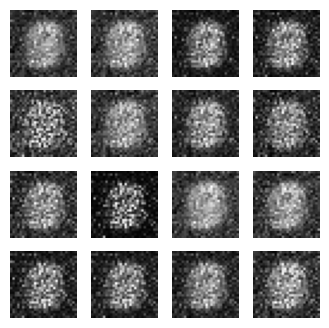

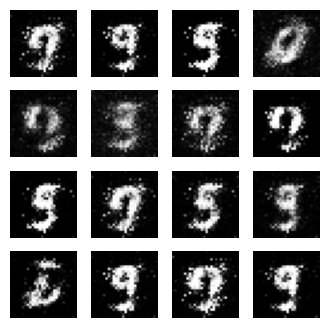

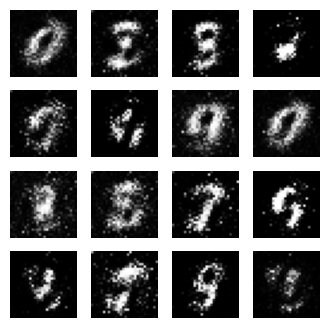

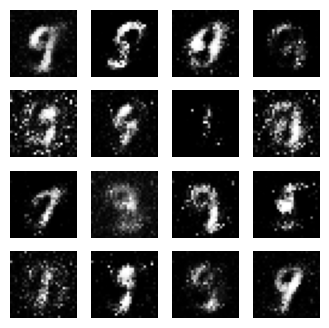

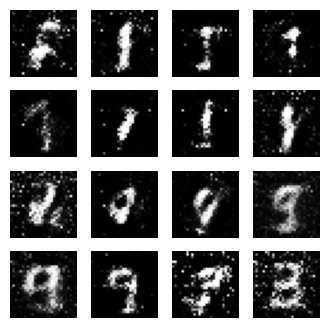

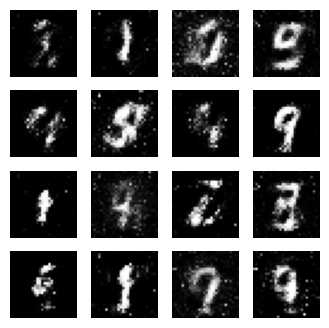

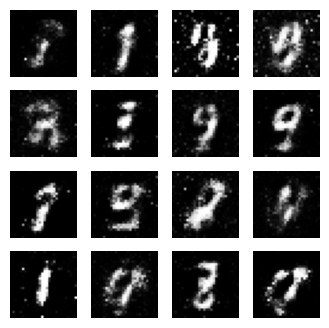

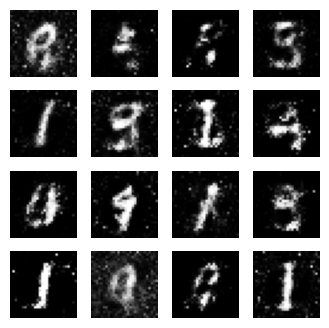

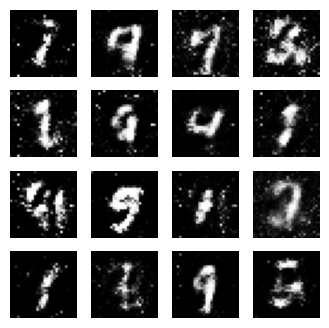

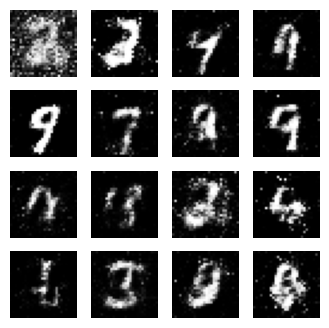

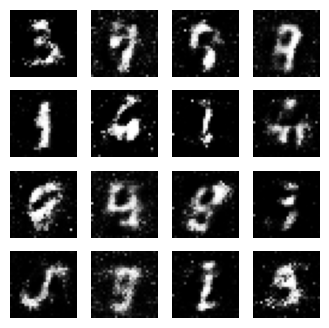

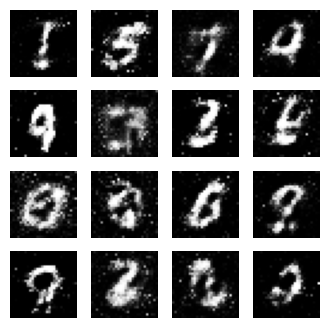

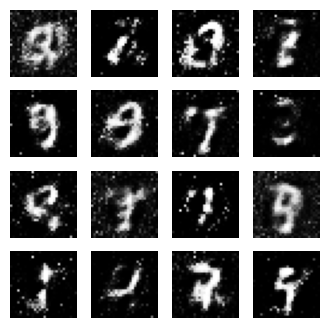

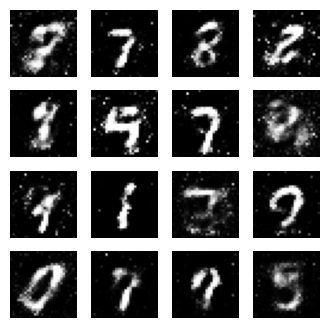

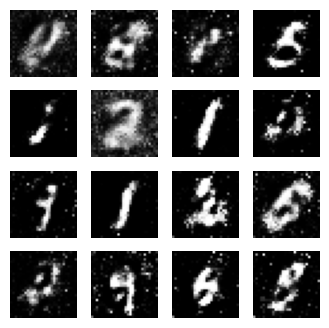

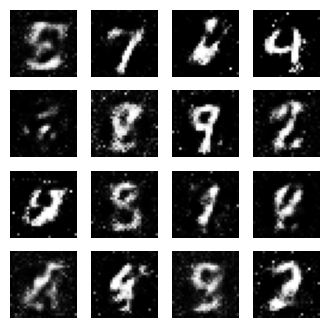

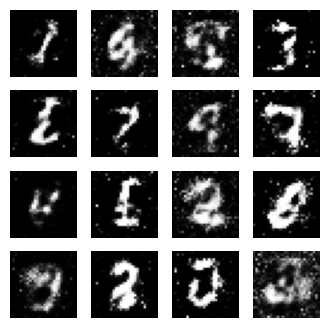

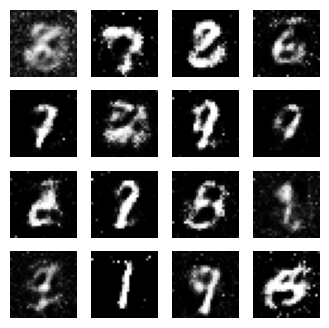

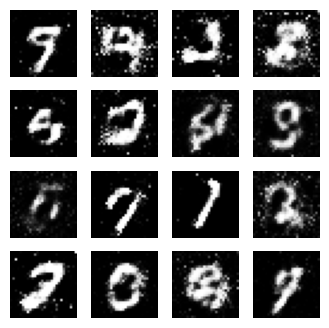

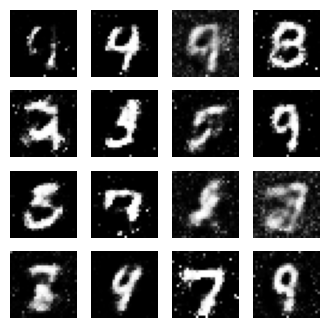

In [64]:
# 하이퍼파라미터 설정
iterations = 20000 # 전체적으로 몇번의 이터레이션동안 학습할 것인지를 결정, 한 이터레이션은 생성자와 판별자가 각각 한번씩 업데이트 되는 것을 의미.
batch_size = 128 # 한번의 이터레이션에서 몇개의 이미지를 사용하여 학습할 것인지를 결정, 배치사이즈가 크면 ㅈ전체데이터셋을 한번에 취급하지만, 메모리를 많이 먹고
# 느려짐.
sample_interval = 1000 # 학습도중에 생성자가 생성한 이미지를 일정간격으로 저장하고 출력하기 위한 변수. 이를 통해 학습이 어느정도 진행되었는지,
# 생성자가 어떤 이미지를 생성하는지를 확인간.ㅇ 

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval) # train()
# iterations: 총 훈련 반복 횟수
# batch_size: 미니배치 크기
# sample_interval: 생성자 모델이 이미지를 생성하고 저장하는 간격 (단위: iteration)

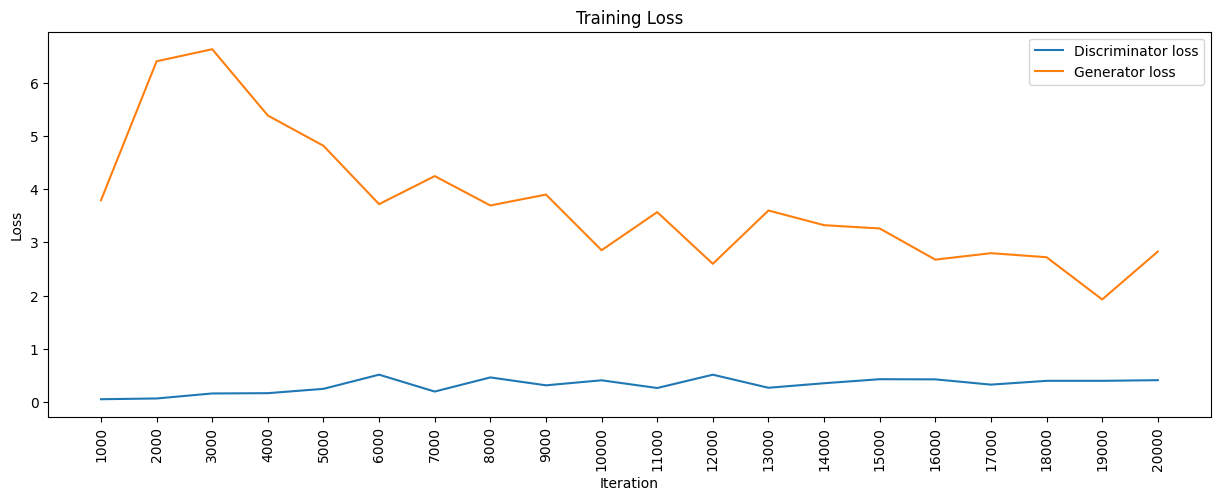

In [65]:
losses = np.array(losses) # 학습 중 저장한 손실값을 넘파이 배열로 ㅂ녀환하는 코드임. 로스는 리스트로 선언되어 있으며, 각 반복마다 계산된 손실값을 리스트에 
# 추가함. 

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss") # T는 전치 메소드를 의미함. 행과 열을 바꿈. T[0]은 판별자 손실.
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss") # T[1]은 생성자 손실임. 

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

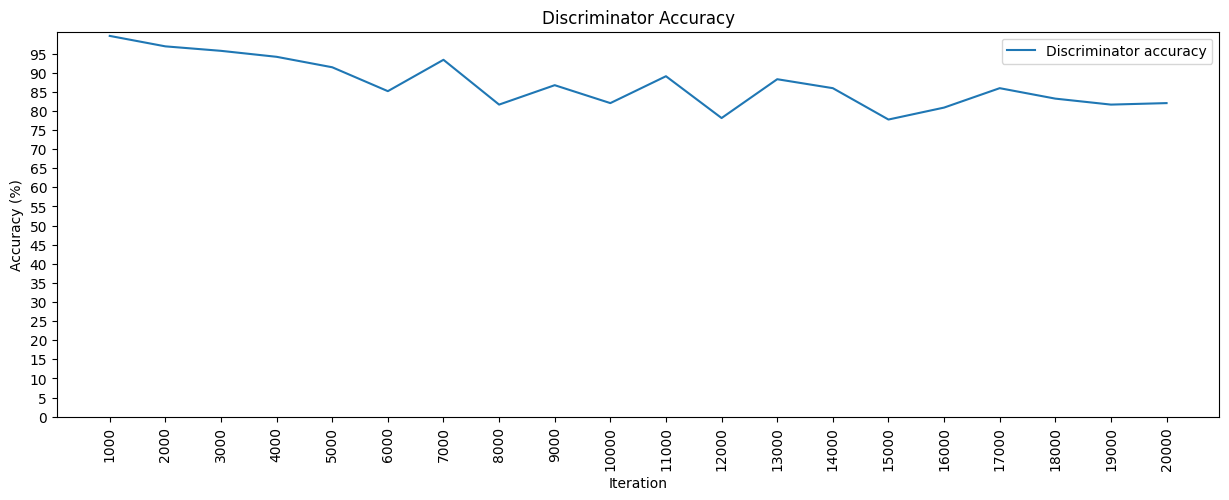

In [66]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()